# About

The purpose of this notebook is to provide a demonstration of how standard DICOM objects containing annotations and evaluations of the nodules for the TCIA [LIDC-IDRI](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI) collection, as presented in the following article, can be examined using Python, `pylidc` and 3D Slicer (https://slicer.org).

> Fedorov A, Hancock M, Clunie D, Brochhausen M, Bona J, Kirby J, Freymann J, Pieper S, Aerts H, Kikinis R, Prior F. 2018. Standardized representation of the LIDC annotations using DICOM. PeerJ Preprints 6:e27378v1 https://doi.org/10.7287/peerj.preprints.27378

The latest version of the notebook is in this repository: https://github.com/qiicr/lidc2dicom

## Prerequisites

This notebook assumes you have the following locally on your computer:
* the notebook is started from the `notebooks` folder of the [`lidc2dicom` repository](https://github.com/QIICR/lidc2dicom) checked out to your computer
* Images from the TCIA LIDC-IDRI collection, see download instructions here: https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI
* DICOM Segmentations and Structured Reporting objects (at the time of writing this, those are located separately from the images), see download instructions here: https://wiki.cancerimagingarchive.net/display/DOI/Standardized+representation+of+the+TCIA+LIDC-IDRI+annotations+using+DICOM
* `pylidc` python package is installed and configured, see https://pylidc.github.io/ (only needed if you want to use the components of the notebook that utilize `pylidc` visualization capabilities)
* [3D Slicer](https://slicer.org) and the [QuantitativeReporting extension](https://qiicr.gitbooks.io/quantitativereporting-guide/content/) (only needed if you want to use the 3D Slicer visualization capabilities)

Note the location of the CT images and derived DICOM data on your computer, and assign those to the `CT_DICOM_PATH` and `DERIVED_DICOM_PATH` variables in the first Python cell of the notebook below.

Once you have the data downloaded to your computer, you should extract the metadata from the CT images and derived objects into tab-separated files, which will be used in this notebook for metadata exploration and verification. You can perform this transformation using the [dcm2tables](https://github.com/QIICR/dcm2tables) tool. You can also download extracted tables [here](http://bit.ly/lidc-dicom-v2-tables).

Note the location of the metadata tab-separated files for the CT images and derived DICOM data on your computer, and assign those to the `CT_TABLES_PATH` and `DERIVED_TABLES_PATH` variables in the first Python cell of the notebook below.

In [42]:
import pylidc as pl
import pandas as pd
import os, json
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook 

CT_DICOM_PATH = "/Users/fedorov/Documents/TCIA/LIDC-IDRI"
CT_TABLES_PATH = "/Users/fedorov/Documents/TCIA/LIDC-IDRI-tables"

# small dataset for testing
DERIVED_DICOM_PATH = "/Users/fedorov/Temp/LIDC_conversion2"
DERIVED_TABLES_PATH = "/Users/fedorov/Temp/LIDC_conversion2-tables"

# complete dataset
DERIVED_DICOM_PATH = "/Users/fedorov/Temp/LIDC_conversion5"
DERIVED_TABLES_PATH = "/Users/fedorov/Temp/LIDC_conversion5-tables"

## CT images metadata

Individual tab-delimited files are loaded into pandas dataframes. Attributes of the CT instances are extracted into `CompositeContext` and `CT` tables. `CompositeContext` contains attributes that are expected to be present in every DICOM instance. `CT` table includes attributes specific to CT, as shown below (the complete schema can be explored [here](https://app.quickdatabasediagrams.com/#/d/K6UbDf)).

![](images/CT_DB_schema.png)

Note that the assignment of the attributes to the tables does not necessarily correspond to the DICOM data model. This assignment is configurable in the schema description file included in the `dcm2tables` repository [here](https://github.com/QIICR/dcm2tables/blob/master/schema.qdbd).

In [43]:
# read CT DICOM metadata tables
imagesTablesNames = [
                # one per DICOM file, attributes that are available in every DICOM object
               'CompositeContext',
    
                # modality-specific attributes
               'CT',
    
               # pointer from the DICOM SOPInstanceUID to the file on the filesystem
               'Instance2File'                     
              ]
imagesTables = {}
for t in imagesTablesNames:
    imagesTables[t]=pd.read_csv(os.path.join(CT_TABLES_PATH,t+'.tsv'), sep='\t', dtype=str, low_memory=False)

## Metadata for the image-derived DICOM objects

Image-derived objects contain 
1. DICOM Segmentations, which contain annotations of the nodules performed by multiple experts. Metadata attributes and the relationship of the tables extracted from those objects is shown below.

![](images/SEG_DB_schema.png)

2. DICOM Structured reports that follow DICOM SR template 1500, containing qualitative evaluation of the nodule appearance, and segmentation-derived measurements.

![](images/SR_DB_schema.png)

In [44]:
# read derived DICOM metadata tables
derivedTablesNames = [
               # one per DICOM file, attributes that are available in every DICOM object
               'CompositeContext',
    
               # when applicable, references to related DICOM objects in the derived datasets
               'References', 
    
               # modality-specific attributes
               'SEG','SR',
    
               # attributes specific to DICOM Segmentations; each Segmentation
               # object contains one or more segment, and each segment contains
               # one or more frame (i.e., "slice") with the labeled pixels
               'SEG_Segments','SEG_SegmentFrames',
    
               # attributes specific to DICOM Structured Reports (SR)
               'SR1500_Measurements','SR1500_MeasurementGroups', 
    
               # qualitative assessments  
               'SR1500_QualitativeEvaluations',     
    
               # pointer from the DICOM SOPInstanceUID to the file on the filesystem
               'Instance2File'        
              ]
derivedTables = {}
for t in derivedTablesNames:
    derivedTables[t]=pd.read_csv(os.path.join(DERIVED_TABLES_PATH,t+'.tsv'), sep='\t', dtype=str, low_memory=False)

# Verification of content consistency

In the following we verify the consistency of the metadata between the DICOM representation (as contained in the dataframes we loaded earlier) and the `pylidc` content for each of the annotations of each of the subjects that were converted. 

In [45]:
totalSubjects = np.max(imagesTables["CompositeContext"]["PatientID"].str.split('-',expand=True)[2].astype(int).values)

In [5]:
# load dictionaries
    
conceptsDictionary = {}
valuesDictionary = {}
with open("../concepts_dict.json") as cf:
  conceptsDictionary = json.load(cf)
with open("../values_dict.json") as vf:
  valuesDictionary = json.load(vf)

subjectsToVerify = [("LIDC-IDRI-%04i" % i) for i in range(1,totalSubjects+1)]

# iterate over data, confirm existence of data, 
# one SEG and one SR per annotation, and consistency of numeric
# and qualitative assessment values between pylidc and DICOM representation
from decimal import *
epsilon = 1e-2

def compareNumbers(v1, v2):
  assert (abs(v1-v2) < epsilon), "Comparison threshold exceeded: %f vs %f!" % (v1, v2) 

def compareStrings(s1, s2):
  assert (s1 == s2), "Comparison strings failed: %s vs %s!" % (s1, s2) 

def compareCodes(c1, c2):
  assert (c1["CodeValue"] == c2["CodeValue"]), "CodeValue mismatch"
  assert (c1["CodeMeaning"] == c2["CodeMeaning"]), "CodeMeaning mismatch"
  assert (c1["CodingSchemeDesignator"] == c2["CodingSchemeDesignator"]), "CodingSchemeDesignator mismatch"

for s in subjectsToVerify:
  print(s)
  scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == s)
  for scan in scans:
    studyUID = scan.study_instance_uid
    seriesUID = scan.series_instance_uid
    ctSeriesDir = os.path.join(CT_DICOM_PATH,s,studyUID,seriesUID)
    derivedSeriesDir = os.path.join(DERIVED_DICOM_PATH, s, studyUID, seriesUID)
    
    referencesSubset = derivedTables["References"][derivedTables["References"]["ReferencedSeriesInstanceUID"] == seriesUID]
    referencingUIDs = pd.unique(referencesSubset["SOPInstanceUID"])
    thoseReferenceSeries = derivedTables["CompositeContext"][derivedTables["CompositeContext"]["SOPInstanceUID"].isin(referencingUIDs)]
    
    segmentations = thoseReferenceSeries[thoseReferenceSeries["Modality"]=="SEG"]
    segmentsSubset = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["SOPInstanceUID"].isin(referencingUIDs)]
    segments = pd.merge(segmentsSubset, segmentations, on=["SOPInstanceUID"])
                
    for nCount,nodule in enumerate(scan.cluster_annotations()):
      for aCount,a in enumerate(nodule):
        
        # this is the convention used to name segments (SegmentDescription and SegmentLabel)
        segmentLabel = "Nodule "+str(nCount+1) +" - Annotation " + a._nodule_id
        
        # Find corresponding segment:
        #  1. find SEGs that reference the SeriesInstanceUID of the CT annotated
        #  2. find the specific SEG using SegmentLabel
        #  3. if there are multiple annotations that have the same ID, we are screwed
        segment = segments[segments["SegmentLabel"] == segmentLabel]
        if segment.shape[0] != 1:
          print("Not 1 matching segment for %s: %i!" % (segmentLabel,segment.shape[0]))
          continue
        #print(str(segment["SOPInstanceUID"].values))
        
        segmentationInstanceUID = segment["SOPInstanceUID"].values[0]
        
        # now get measurement groups that correspond to those Structured Reports instances
        # For the specific dataset, we know there is a single measurement group per segment,
        #  and we also know there is a single segment per segmentation, so this makes life easier
        measurementGroups = derivedTables["SR1500_MeasurementGroups"][derivedTables["SR1500_MeasurementGroups"]["segmentationSOPInstanceUID"] == segmentationInstanceUID]
        assert (measurementGroups.shape[0] == 1), "Not one measurement group per segment: %i!" % measurementGroupsSubset.shape[0]
        structuredReportUID = measurementGroups["SOPInstanceUID"].values[0]
        
        qualEval = derivedTables["SR1500_QualitativeEvaluations"][derivedTables["SR1500_QualitativeEvaluations"]["SOPInstanceUID"] == structuredReportUID]
        quantEval = derivedTables["SR1500_Measurements"][derivedTables["SR1500_Measurements"]["SOPInstanceUID"] == structuredReportUID]        
        
        # check quantitative measurements
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values) == 1), "Number of measurements is not one!"
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Diameter"]["value"].values) == 1), "Number of measurements is not one!"
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Surface area of mesh"]["value"].values) == 1), "Number of measurements is not one!"

        dcmVolume = quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values[0]
        dcmDiameter = quantEval[quantEval["quantity_CodeMeaning"]=="Diameter"]["value"].values[0]
        dcmSurface = quantEval[quantEval["quantity_CodeMeaning"]=="Surface area of mesh"]["value"].values[0]
        
        compareStrings(dcmVolume,  ("%E" % Decimal(a.volume)))
        compareStrings(dcmDiameter, ("%E" % Decimal(a.diameter)))
        compareStrings(dcmSurface, ("%E" % Decimal(a.surface_area)))
            
        dcmStr = quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values[0]
        
        # check code values
        for attribute in conceptsDictionary.keys():
          aItem = {}

          # this specific annotation is known to have an invalid value for internalStructure, which was intentionally
          # not included in DICOM representation
          if attribute == "internalStructure" and segmentLabel == "Nodule 8 - Annotation 1708" and s == "LIDC-IDRI-0510":
            #print("  Skipping knowingly faulty item")
            continue
        
          try:
            aItem["conceptCode"] = conceptsDictionary[attribute]
            aItem["conceptValue"] = valuesDictionary[attribute][str(getattr(a, attribute))]
          
          except KeyError:
            print("   > "+segmentLabel)
            print(" Invalid attribute: "+attribute+': '+str(getattr(a, attribute))+" "+segmentLabel)
            
          if qualEval[qualEval["conceptCode_CodeMeaning"]==aItem["conceptCode"]["CodeMeaning"]].shape[0] != 1:
            print("   > "+segmentLabel)
            print("  Failed to find quantitative assessment for %s in DICOM representation" % aItem["conceptCode"]["CodeMeaning"])
            continue

          dcmItem = qualEval[qualEval["conceptCode_CodeMeaning"]==aItem["conceptCode"]["CodeMeaning"]]
          compareCodes(aItem["conceptValue"], {"CodeValue": dcmItem["conceptValue_CodeValue"].values[0], \
                                               "CodeMeaning": dcmItem["conceptValue_CodeMeaning"].values[0], \
                                               "CodingSchemeDesignator": dcmItem["conceptValue_CodingSchemeDesignator"].values[0]})

LIDC-IDRI-0001
LIDC-IDRI-0002
LIDC-IDRI-0003
LIDC-IDRI-0004
LIDC-IDRI-0005


KeyboardInterrupt: 

# Visualization

The following are helper functions to facilitate visualization of the specific annotations and the corresponding CT images using either custom capabilities of `pylidc`, or generic functionality of 3D Slicer QuantitativeReporting extension.

**NOTE**: you will need to change the `slicerAppBinary` in the cell below to point to the location of the 3D Slicer application on your computer!

In [46]:
import tempfile, subprocess
slicerAppBinary = "/Applications/Slicer.app/Contents/MacOS/Slicer"

def showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, srSeriesUID=None, seriesDescriptionPrefix=None):
  # read the template startup script
  # populate directories placeholders
  # ctDICOMDir, derivedDICOMDir
  templateScriptFile = "../slicerLoaderTemplate.py"
  templateScript = open(templateScriptFile, 'r').read()
  templateScript = templateScript.replace("<CT_DICOM_PATH_PLACEHOLDER>", ctDICOMDir)
  templateScript = templateScript.replace("<DERIVED_DICOM_PATH_PLACEHOLDER>", derivedDICOMDir)

  if srSeriesUID is not None:
    templateScript = templateScript.replace("<SR_SERIES_UID_PLACEHOLDER>", "\""+srSeriesUID+"\"")
  else:
    templateScript = templateScript.replace("<SR_SERIES_UID_PLACEHOLDER>", "None")

  if seriesDescriptionPrefix is not None:
    templateScript = templateScript.replace("<SERIES_DESCRIPTION_PREFIX_PLACEHOLDER>", "\""+seriesDescriptionPrefix+"\"")
  else:
    templateScript = templateScript.replace("<SERIES_DESCRIPTION_PREFIX_PLACEHOLDER>", "None")    
    
  tmpfile = tempfile.mktemp()+".py"
  startupScriptFile = open(tmpfile, "w")
  startupScriptFile.write(templateScript)
  startupScriptFile.close()
  print("Slicer python startup script is in\n "+tmpfile)
    
  slicerCmd = [slicerAppBinary, "--python-script", tmpfile]
  sp = subprocess.Popen(slicerCmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  sp.wait()
  (stdout,stderr) = sp.communicate() 
  print(stdout)
  print(stderr)

In [47]:
def getPylidcAnnotationByLabel(subjectID, segmentLabel):
  result = None
  print("Looking for \""+segmentLabel+"\"")
  scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == subjectID)
  for scan in scans:
    for nCount,nodule in enumerate(scan.cluster_annotations()):
      for aCount,a in enumerate(nodule):
        label = "Nodule "+str(nCount+1) +" - Annotation " + a._nodule_id
        if label == segmentLabel:
          result = a
  return result

def getCTSEGSRSeriesUIDsForSegment(subjectID, segmentLabel):
  # showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, srSeriesUID=None, seriesDescriptionPrefix=None):
  # first, find that subject in the 

  ctSeriesUID = None
  segSeriesUID = None
  srSeriesUID = None
  studyUID = None

  segment = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["SegmentLabel"] == segmentLabel]
  segment = pd.merge(segment,derivedTables["CompositeContext"], on=["SOPInstanceUID"])

  assert (segment.shape[0] == 1), "Not 1 matching segment for %s: %i!" % (segmentLabel,segment.shape[0]) 

  segSeriesUID = segment["SeriesInstanceUID"].values[0]
  segInstanceUID = segment["SOPInstanceUID"].values[0]

  # we know each segmentation references one and only one CT series
  ctSeriesUID = derivedTables["References"][derivedTables["References"]["SOPInstanceUID"]==segInstanceUID]["ReferencedSeriesInstanceUID"].values[0]
        
  # now get measurement groups that correspond to those Structured Reports instances
  # For the specific dataset, we know there is a single measurement group per segment,
  #  and we also know there is a single segment per segmentation, so this makes life easier
  measurementGroups = derivedTables["SR1500_MeasurementGroups"][derivedTables["SR1500_MeasurementGroups"]["segmentationSOPInstanceUID"] == segInstanceUID]
  measurementGroups = pd.merge(measurementGroups, derivedTables["CompositeContext"], on=["SOPInstanceUID"])
  assert (measurementGroups.shape[0] == 1), "Not one measurement group per segment: %i!" % measurementGroupsSubset.shape[0]
  srSeriesUID = measurementGroups["SeriesInstanceUID"].values[0]
  studyUID = measurementGroups["StudyInstanceUID"].values[0]
    
  return (studyUID, ctSeriesUID, segSeriesUID, srSeriesUID)

In [48]:
%matplotlib notebook
def showNodule(showIn="pylidc", noduleUID=None, showAllAnnotations=True):
  segmentsSubset = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["TrackingUID"]==noduleUID]
  segmentsSubsetWithContext = pd.merge(segmentsSubset, derivedTables["CompositeContext"], on="SOPInstanceUID")
  noduleLabel = segmentsSubsetWithContext["SegmentLabel"].values[0]
  subject = segmentsSubsetWithContext["PatientID"].values[0]
  studyUID = segmentsSubsetWithContext["StudyInstanceUID"].values[0]
  ctSeriesUID = imagesTables["CompositeContext"][imagesTables["CompositeContext"]["PatientID"]==subject]["SeriesInstanceUID"].values[0]
  print(noduleLabel)
  print(subject)
  print(studyUID)
  print(ctSeriesUID)
  if showIn == "pylidc":
    a = getPylidcAnnotationByLabel(subject, noduleLabel)
    a.visualize_in_scan()
  elif showIn == "slicer":
    ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctSeriesUID)
    derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)
    if showAllAnnotations:
      showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, seriesDescriptionPrefix=noduleLabel.split('-')[0])
    else:
      showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, seriesDescriptionPrefix=noduleLabel)
  else:
    print("Unexpected argument - showIn can be either pylidc or slicer")
    
    # (ctDICOMDir, derivedDICOMDir, srSeriesUID=None, seriesDescriptionPrefix=None)

### Example of visualizing a specific annotation using `pylidc`

Looking for "Nodule 2 - Annotation 16831"
Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>


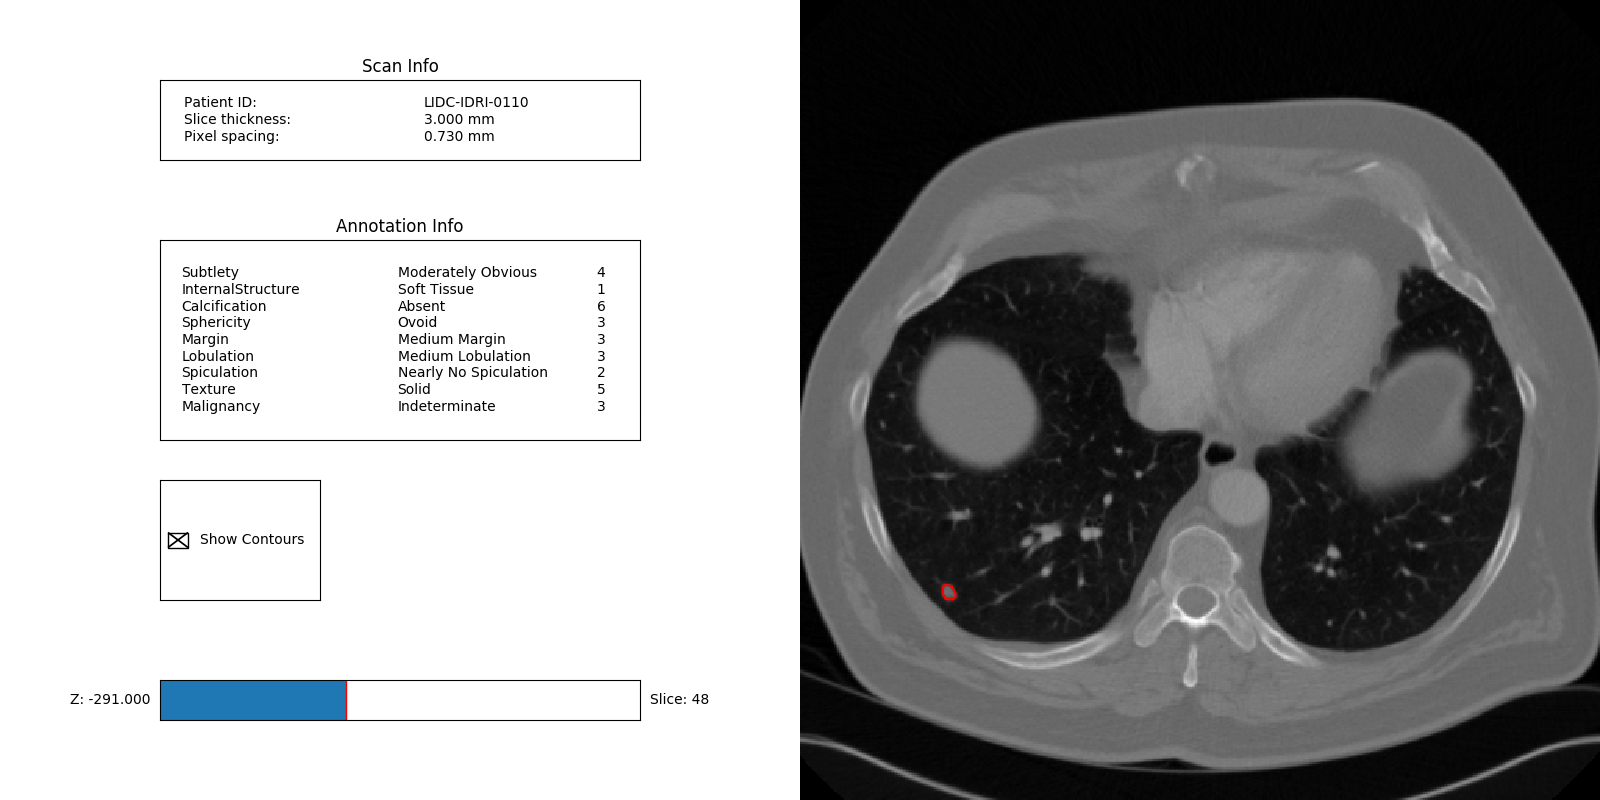

In [49]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

subject = "LIDC-IDRI-0005"
annotationLabel = "Nodule 2 - Annotation MI014_11887"

subject = "LIDC-IDRI-0006"
annotationLabel = "Nodule 4 - Annotation IL057_127062"

subject = "LIDC-IDRI-0003"
annotationLabel = "Nodule 1 - Annotation 12"

subject = "LIDC-IDRI-0110"
annotationLabel = "Nodule 2 - Annotation 16831"

a = getPylidcAnnotationByLabel(subject, annotationLabel)

a.visualize_in_scan()



### Example of visualizing a specific annotation using 3D Slicer

Slicer will start externally. Note that for some of the nodules/subjects that contain a lot of annotations it can take some time for the data to load. You can always interrupt the process by hitting the "Stop" button in the Jupyter control bar.

In [28]:
(studyUID, ctUID, segUID, srUID) = getCTSEGSRSeriesUIDsForSegment(subject, annotationLabel)

ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctUID)
derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)

showSubjectInSlicer(ctDICOMDir, derivedDICOMDir)

Slicer python startup script is in
 /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmp64uk677i.py
b'Switch to module:  "Welcome"\nSwitching to temporary DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nOriginal DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nInput directory: /Users/fedorov/Documents/TCIA/LIDC-IDRI/LIDC-IDRI-0110/1.3.6.1.4.1.14519.5.2.1.6279.6001.924939006160714533549353726515/1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717834916358933873912\nNew patient inserted: 1\nNew patient inserted as :  1\nNeed to insert new study:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.924939006160714533549353726515"\nStudy Added\nNeed to insert new series:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717834916358933873912"\nSeries Added\n"DICOM indexer has successfully processed 125 files [0.74s]"\n(u\'1\',)\nImport completed, total 1 patients imported\nInput directory: /Users/fedorov/Temp/LIDC_conversion5/LIDC-IDRI-0110/1.3.6.1.4.1.14519.5.2.1.6279.6001.924

## Data exploration

Note that the meaning of a specific DICOM attribute can be looked up at https://dicom.innolitics.com/ciods (as an example)

### CT Images

How many CT series do we have? Which subjects have more than one CT series?

First, we merge CT and CT CompositeContext tables. Then we can drop all duplicate occurrences of SeriesInstanceUID, and count the number of occurrences of PatientID instances.

In [50]:
ct = pd.merge(imagesTables["CT"], imagesTables["CompositeContext"], on="SOPInstanceUID")
series = ct.drop_duplicates(subset="SeriesInstanceUID")
print("Total CT series: "+str(series.shape[0]))

Total CT series: 1018


In [51]:
subjectCount = series["PatientID"].value_counts()
subjectCount[subjectCount>1]

LIDC-IDRI-0332    2
LIDC-IDRI-0355    2
LIDC-IDRI-0132    2
LIDC-IDRI-0442    2
LIDC-IDRI-0315    2
LIDC-IDRI-0151    2
LIDC-IDRI-0484    2
LIDC-IDRI-0365    2
Name: PatientID, dtype: int64

Examine various aspects evaluating heterogeneity of acquisition in the data.

count    1018.000000
mean        1.918713
std         0.728916
min         0.600000
25%         1.250000
50%         2.000000
75%         2.500000
max         5.000000
Name: SliceThickness, dtype: float64

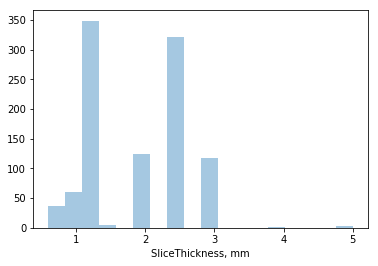

In [52]:
%matplotlib inline
ax=sb.distplot(series["SliceThickness"].astype(float),kde=False)
ax.set(xlabel="SliceThickness, mm")
series["SliceThickness"].astype(float).describe()

count    1018.000000
mean        0.687689
std         0.084851
min         0.460938
25%         0.625000
50%         0.698609
75%         0.742188
max         0.976562
Name: 0, dtype: float64

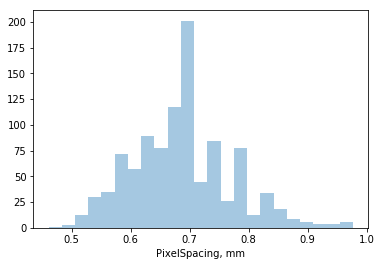

In [53]:
xSpacing = series["PixelSpacing"].str.split('/',n=1,expand=True)[0].astype(float)
ax=sb.distplot(xSpacing, kde=False)
ax.set(xlabel="PixelSpacing, mm")
xSpacing.describe()

Tube current range: 40.0 to 639.0


count    1018.000000
mean      227.349705
std       145.946150
min        40.000000
25%        80.000000
50%       240.000000
75%       320.000000
max       639.000000
Name: XRayTubeCurrent, dtype: float64

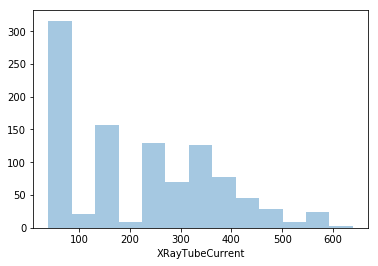

In [54]:
sb.distplot(series["XRayTubeCurrent"].astype(float),kde=False)
minCurrent=np.min(series["XRayTubeCurrent"].astype(float))
maxCurrent=np.max(series["XRayTubeCurrent"].astype(float))
print("Tube current range: "+str(minCurrent)+" to "+str(maxCurrent))
series["XRayTubeCurrent"].astype(float).describe()

### Segmentations

First look at the overall summary of the annotations - number of annotations per nodule, and number of nodules per subject.

Total annotations: 6859
Total nodules: 2651


[Text(0.5, 0, 'annotations per nodule')]

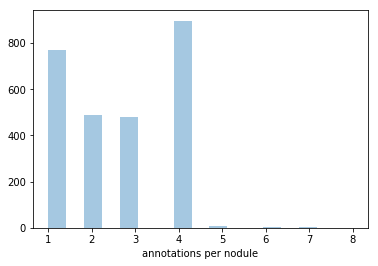

In [55]:
segmentsWithContext = pd.merge(derivedTables["SEG_Segments"], derivedTables["CompositeContext"], on="SOPInstanceUID")
print("Total annotations: "+str(derivedTables["SEG_Segments"].shape[0]))
print("Total nodules: "+str(segmentsWithContext.drop_duplicates(subset="TrackingUID").shape[0]))

# annotations per nodule
annotationsPerNodule = segmentsWithContext["TrackingUID"].value_counts()
ax=sb.distplot(annotationsPerNodule,kde=False) #.set_title("Number of annotations per nodule")
ax.set(xlabel="annotations per nodule")

count    875.000000
mean       3.029714
std        2.680386
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       23.000000
Name: PatientID, dtype: float64

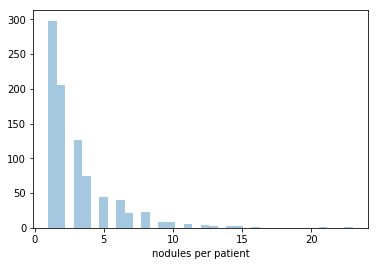

In [56]:
# nodules per subject
oneAnnotationPerNodule=segmentsWithContext.drop_duplicates(subset="TrackingUID")["PatientID"].value_counts()
ax=sb.distplot(oneAnnotationPerNodule,kde=False) #.set_title("Number of nodules per patient")
ax.set(xlabel="nodules per patient")
oneAnnotationPerNodule.describe()

count    875.000000
mean       7.838857
std        6.805594
min        1.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       49.000000
Name: PatientID, dtype: float64

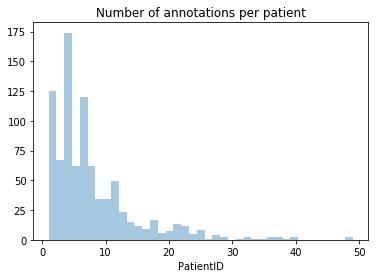

In [57]:
# annotations per subject
annotationsPerPatient=segmentsWithContext["PatientID"].value_counts()
sb.distplot(annotationsPerPatient,kde=False).set_title("Number of annotations per patient")
annotationsPerPatient.describe()

If there is an interesting annotation or subject to look in more detail, the earlier introduced visualization tools can be used to look at it.

In [58]:
# who has most nodules?
oneAnnotationPerNodule.head(3)

LIDC-IDRI-0583    23
LIDC-IDRI-0686    21
LIDC-IDRI-0855    16
Name: PatientID, dtype: int64

After running the cell below, you should see something like this:
    
![](images/LIDC-IDRI-0583.png)

In [50]:
### NB: This one takes a long time to load!!!

# check if that subject had more than one CT series, then display the image and segmentations
subject = "LIDC-IDRI-0583"
subjectStudies = imagesTables["CompositeContext"][imagesTables["CompositeContext"]["PatientID"]==subject].drop_duplicates(subset="StudyInstanceUID")["StudyInstanceUID"]
print(subject+" has "+str(subjectStudies.shape[0])+" imaging study/studies")
studyUID = subjectStudies.values[0]

studySeries = imagesTables["CompositeContext"][imagesTables["CompositeContext"]["StudyInstanceUID"]==studyUID].drop_duplicates(subset="SeriesInstanceUID")["SeriesInstanceUID"]
print(subject+" has "+str(studySeries.shape[0])+" imaging series")
ctUID = studySeries.values[0]

ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctUID)
derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)

showSubjectInSlicer(ctDICOMDir, derivedDICOMDir)

LIDC-IDRI-0583 has 1 imaging study/studies
LIDC-IDRI-0583 has 1 imaging series
Slicer python startup script is in
 /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmptuv245fn.py
b'Switch to module:  "Welcome"\nSwitching to temporary DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nOriginal DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nInput directory: /Users/fedorov/Documents/TCIA/LIDC-IDRI/LIDC-IDRI-0583/1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802\nNew patient inserted: 1\nNew patient inserted as :  1\nNeed to insert new study:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.230901123329037029807195618747"\nStudy Added\nNeed to insert new series:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802"\nSeries Added\n"DICOM indexer has successfully processed 290 files [1.88s]"\n(u\'1\',)\nImport completed, total 1 patients imported\nInput directory: /Users/fed

### Evaluations and measurements

* sort by size
* dependencies between size/surface and something else
* dependencies between acquisition parameters and interpretations
* variability of volume/surface as a function of margin type?

In [59]:
derivedTables["SR1500_Measurements"].columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator',
       'measurementAlgorithmIdentification_AlgorithmName',
       'measurementAlgorithmIdentification_AlgorithmVersion',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value'],
      dtype='object')

In [60]:
print(derivedTables["SR1500_Measurements"].shape)
print(derivedTables["CompositeContext"].shape)
measurementsWithContext = pd.merge(derivedTables["SR1500_Measurements"], derivedTables["CompositeContext"], on="SOPInstanceUID")
print("Merged dataframe: "+str(measurementsWithContext.shape))

(20577, 17)
(13718, 23)
Merged dataframe: (20577, 39)


count     6859.000000
mean       760.283481
std       1826.968420
min          6.801801
25%         77.952480
50%        160.380000
75%        502.783750
max      31112.200000
Name: value, dtype: float64

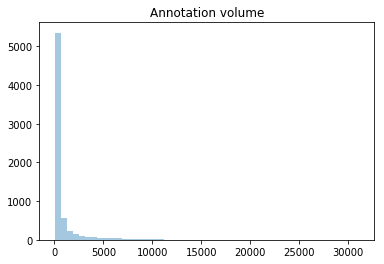

In [61]:
volumes = measurementsWithContext[measurementsWithContext["quantity_CodeMeaning"]=="Volume"]
sb.distplot(volumes["value"].astype(float).values,kde=False).set_title("Annotation volume")
volumes["value"].astype(float).describe()

In [62]:
# is that largest tumor an outlier?
largest = volumes[volumes["value"].astype(float)==np.max(volumes["value"].astype(float).values)]
subject = largest["PatientID"].values[0]
noduleUID = largest["TrackingUniqueIdentifier"].values[0]
studyUID = pd.unique(largest["StudyInstanceUID"])[0]
ctUID = imagesTables["CompositeContext"]
ctUID = pd.unique(ctUID[ctUID["PatientID"]==subject]["SeriesInstanceUID"])[0]
annotationLabel = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["TrackingUID"]==noduleUID]["SegmentLabel"].values[0]

In [63]:
print(subject)
print(annotationLabel)

LIDC-IDRI-0834
Nodule 1 - Annotation 13592


Looking for "Nodule 1 - Annotation 13592"
Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>


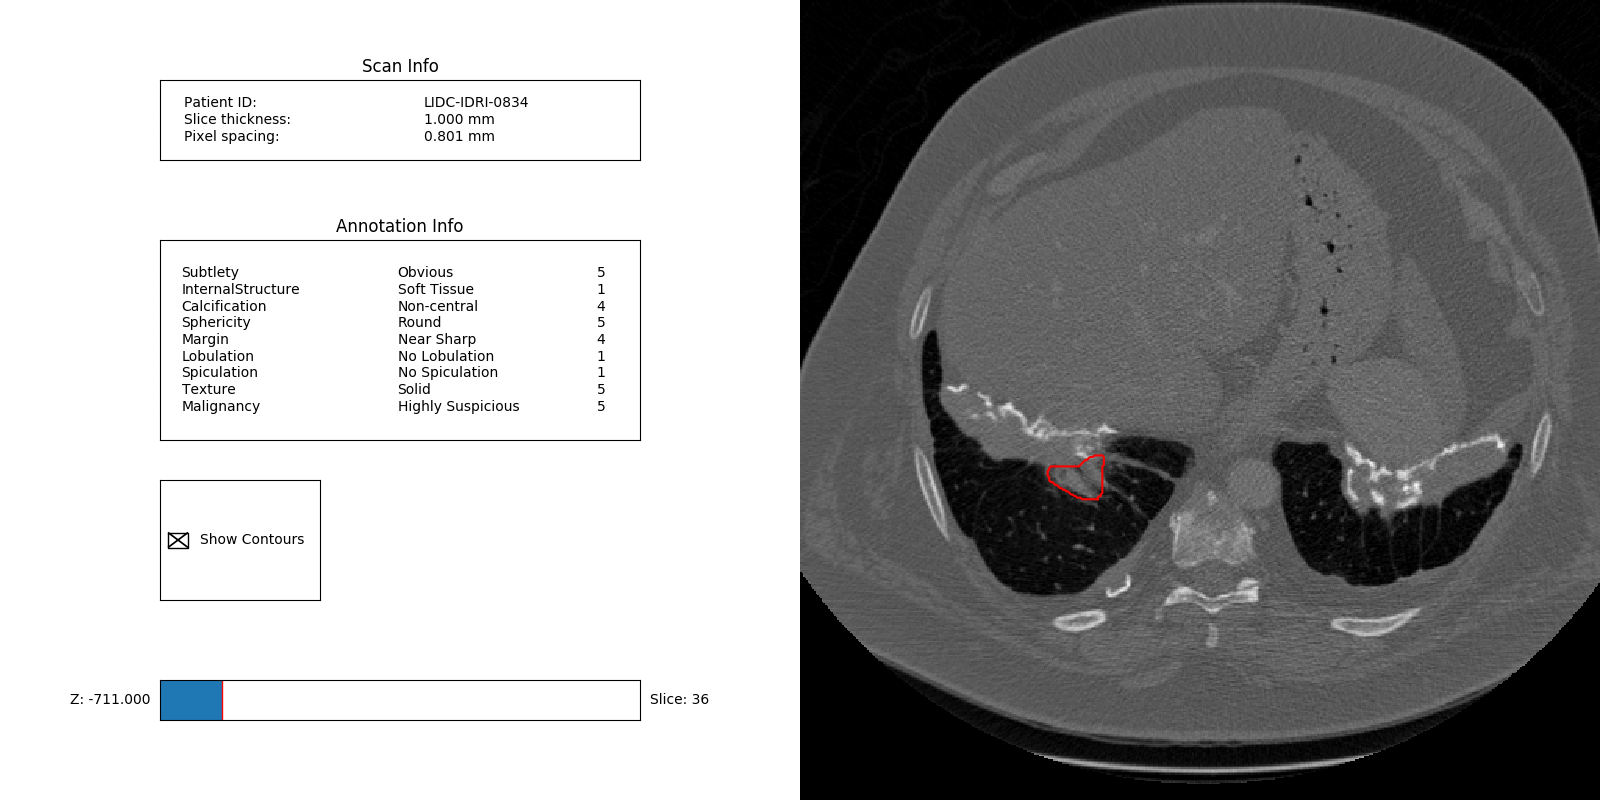

In [64]:
%matplotlib notebook
subject = "LIDC-IDRI-0834"
annotationLabel = "Nodule 1 - Annotation 13592"

a = getPylidcAnnotationByLabel(subject, annotationLabel)

a.visualize_in_scan()

In [221]:
(studyUID, ctUID, segUID, srUID) = getCTSEGSRSeriesUIDsForSegment(subject, annotationLabel)

ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctUID)
derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)

showSubjectInSlicer(ctDICOMDir, derivedDICOMDir)

Written content to /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmpep7e69v1.py
b'Switch to module:  "Welcome"\nSwitching to temporary DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nOriginal DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nInput directory: /Users/fedorov/Documents/TCIA/LIDC-IDRI/LIDC-IDRI-0834/1.3.6.1.4.1.14519.5.2.1.6279.6001.224985459390356936417021464571/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680\nNew patient inserted: 1\nNew patient inserted as :  1\nNeed to insert new study:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.224985459390356936417021464571"\nStudy Added\nNeed to insert new series:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680"\nSeries Added\n"DICOM indexer has successfully processed 280 files [1.79s]"\n(u\'1\',)\nImport completed, total 1 patients imported\nInput directory: /Users/fedorov/Temp/LIDC_conversion5/LIDC-IDRI-0834/1.3.6.1.4.1.14519.5.2.1.6279.6001.22498545939035693641

In [65]:
derivedTables["SR1500_QualitativeEvaluations"].columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier', 'conceptCode_CodeMeaning',
       'conceptCode_CodeValue', 'conceptCode_CodingSchemeDesignator',
       'conceptValue_CodeMeaning', 'conceptValue_CodeValue',
       'conceptValue_CodingSchemeDesignator'],
      dtype='object')

In [66]:
qualitativeWithContext = pd.merge(derivedTables["SR1500_QualitativeEvaluations"], derivedTables["CompositeContext"], on="SOPInstanceUID")
concepts = pd.unique(qualitativeWithContext["conceptCode_CodeMeaning"])
concepts

array(['Subtlety score', 'Internal structure', 'Calcification',
       'Sphericity', 'Margin', 'Lobular Pattern', 'Spiculation',
       'Texture', 'Malignancy'], dtype=object)

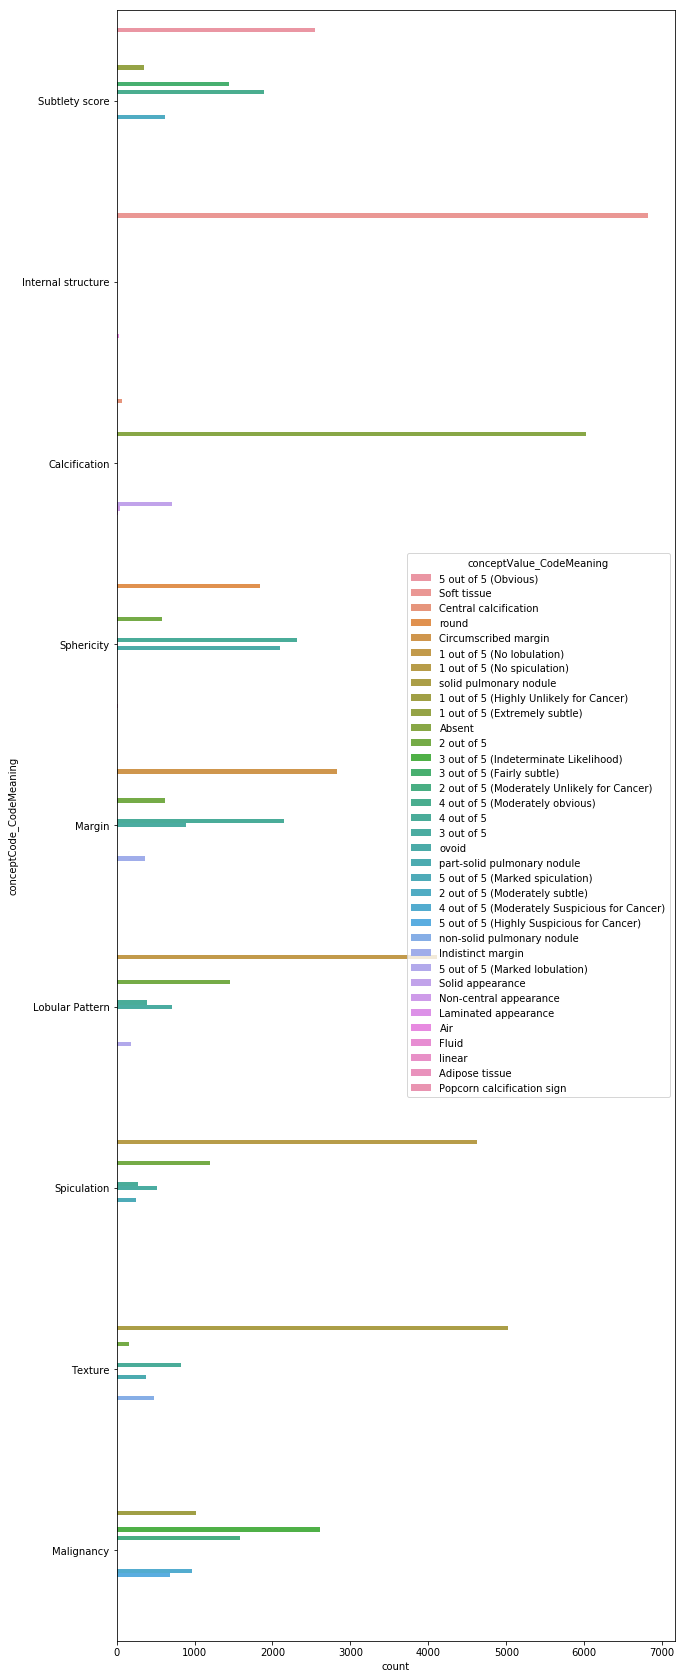

In [67]:
#g = sb.FacetGrid(qualitative, col="subject", col_wrap=3, height=2)
#g.map(sb.countplot, "conceptCode_CodeMeaning", "conceptValue_CodeMeaning", color=".3");

#g = sb.FacetGrid(qualitative, col="conceptCode_CodeMeaning", col_wrap=3)
#g.map(sb.countplot, "conceptValue_CodeMeaning", color=".3", orient="v")
%matplotlib inline
plt.figure(figsize=(10, 30))
sb.countplot(y="conceptCode_CodeMeaning", hue="conceptValue_CodeMeaning", data=qualitativeWithContext)


In [68]:

qualitativeWithContext[qualitativeWithContext["conceptCode_CodeMeaning"]=="Internal structure"]["conceptValue_CodeMeaning"].value_counts()


Soft tissue       6819
Air                 27
Fluid               11
Adipose tissue       1
Name: conceptValue_CodeMeaning, dtype: int64

In [69]:
pd.unique(qualitativeWithContext[qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin"]["conceptValue_CodeMeaning"])

array(['Circumscribed margin', '4 out of 5', '3 out of 5', '2 out of 5',
       'Indistinct margin'], dtype=object)

In [70]:
qualitativeWithContext.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier', 'conceptCode_CodeMeaning',
       'conceptCode_CodeValue', 'conceptCode_CodingSchemeDesignator',
       'conceptValue_CodeMeaning', 'conceptValue_CodeValue',
       'conceptValue_CodingSchemeDesignator', 'BodyPartExamined',
       'EquipmentUID', 'InstitutionName', 'ManufacturerModelName', 'Modality',
       'PatientAge', 'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'ProductId', 'SOPClassUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StationName',
       'StudyDate', 'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

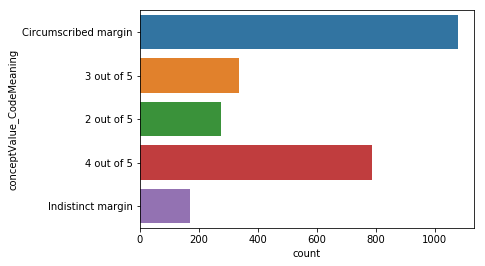

In [71]:
# check if the shape of the distribution is similar across all annotations, and taking one read per annotations
marginEvaluations = qualitativeWithContext[qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin"]
p=sb.countplot(y=marginEvaluations.drop_duplicates(subset="TrackingUniqueIdentifier")["conceptValue_CodeMeaning"])
#p.set_title("Margin assessments / one per nodule")

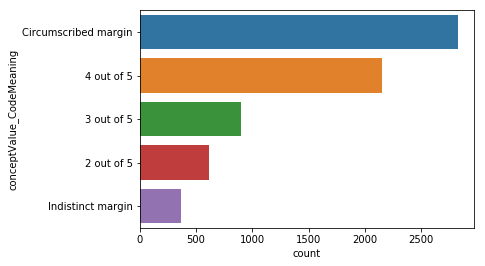

In [72]:
marginEvaluations = qualitativeWithContext[qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin"]
sb.countplot(y=marginEvaluations["conceptValue_CodeMeaning"]) #.set_title("Margin assessments / all annotations")

In [73]:
# count all margin assessments per nodule
marginEvaluations["TrackingUniqueIdentifier"].value_counts()

2.25.77307237104657828236453589659576275176951464182017742124908    8
2.25.92409699894734534728517062016963233512344172224221097796496    7
2.25.70500077330627542426661861947822844011020593829460574987184    7
2.25.60100966155618240440745878017681824180047578130661740924425    7
2.25.35410363045385515693196685718897912544726257017130914281390    6
2.25.19021265325593383368411690106574002039729755006330864394525    6
2.25.79394010365444626964547552980770795327174836227228037195103    5
2.25.52571642330729647010544683780550997779005717772476742445974    5
2.25.84427219692963039904359324783658706524300146994559864242156    5
2.25.52442271212556195635309421424238495142866472302490330507110    5
2.25.15182122287442160862140609498816741076492809093747272728700    5
2.25.99074937262123523052408612875379627377283577345959063314274    5
2.25.50112982002996582483262031114750191585202383133864370911059    5
2.25.61534881640895548342167044802313034323484930151051658129091    5
2.25.105411165179618

In [37]:
# how is it possible to have more than 4 evaluations per nodule? Let's look at this one.
noduleUID = "2.25.77307237104657828236453589659576275176951464182017742124908"
marginEvaluationsSubset = marginEvaluations[marginEvaluations["TrackingUniqueIdentifier"]==noduleUID]
subject = marginEvaluationsSubset["PatientID"].values[0]
studyUID = marginEvaluationsSubset["StudyInstanceUID"].values[0]
ctUID = imagesTables["CompositeContext"]
ctUID = pd.unique(ctUID[ctUID["PatientID"]==subject]["SeriesInstanceUID"])[0]

ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctUID)
derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)

# and it looks like nodules were clustered together because one reader segmented two nodules as one ...
# perhaps more than 4 annotations can be used to select nodules that are incorrectly clustered
showSubjectInSlicer(ctDICOMDir, derivedDICOMDir)

Slicer python startup script is in
 /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmps8wwh_ff.py


KeyboardInterrupt: 

In [74]:
# are there any patterns between image resolution and margin assessment?
ctWithContext = pd.merge(imagesTables["CT"], imagesTables["CompositeContext"], on="SOPInstanceUID")
ctWithContext=ctWithContext.drop_duplicates(subset="StudyInstanceUID")
print("CT shape:"+str(ctWithContext.shape))
print("Evaluations shape:"+str(marginEvaluations.shape))
marginEvaluationWithCT = pd.merge(marginEvaluations, ctWithContext, on="StudyInstanceUID")
marginEvaluationWithCT.shape

CT shape:(1018, 43)
Evaluations shape:(6859, 30)


(6859, 72)

In [75]:
marginEvaluationWithCT.columns

Index(['SOPInstanceUID_x', 'TrackingUniqueIdentifier',
       'conceptCode_CodeMeaning', 'conceptCode_CodeValue',
       'conceptCode_CodingSchemeDesignator', 'conceptValue_CodeMeaning',
       'conceptValue_CodeValue', 'conceptValue_CodingSchemeDesignator',
       'BodyPartExamined_x', 'EquipmentUID_x', 'InstitutionName_x',
       'ManufacturerModelName_x', 'Modality_x', 'PatientAge_x', 'PatientID_x',
       'PatientName_x', 'PatientSex_x', 'PatientWeight_x', 'ProductId_x',
       'SOPClassUID_x', 'SeriesDate_x', 'SeriesDescription_x',
       'SeriesInstanceUID_x', 'SeriesTime_x', 'SoftwareVersions_x',
       'StationName_x', 'StudyDate_x', 'StudyDescription_x',
       'StudyInstanceUID', 'StudyTime_x', 'Unnamed: 0_x', 'Columns',
       'ConvolutionKernel', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType',
       'FocalSpots', 'FrameOfReferenceUID', 'GeneratorPower',
       'ImageOrientationPatient', 'ImagePositionPatient', 'PixelS

In [76]:

pd.unique(marginEvaluationWithCT["SliceThickness"])

array(['2.500000', '2', '1.250000', '3.0', '2.0', '1.0', '3', '1', '0.6',
       '0.75', '1.00', '2.00', '1.25', '1.50', '5', '4', '0.90'],
      dtype=object)

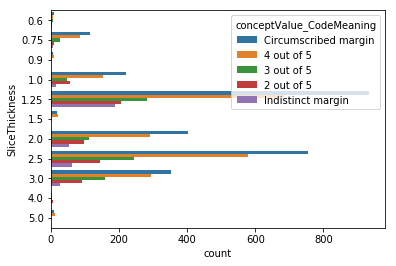

In [77]:
#tempDF = pd.DataFrame({"SliceThickness":marginEvaluationWithCT["SliceThickness"], "Margin":marginEvaluationWithCT["conceptValue_CodeMeaning"]})
#g = sb.FacetGrid(tempDF, col="SliceThickness", hue="Margin")
#g.map(sb.countplot)



marginEvaluationWithCT["SliceThickness"]=marginEvaluationWithCT["SliceThickness"].astype(float)
sb.countplot(y="SliceThickness", hue="conceptValue_CodeMeaning", data=marginEvaluationWithCT)


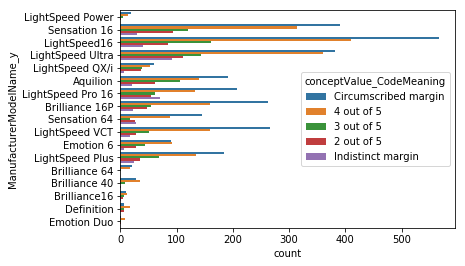

In [78]:
sb.countplot(y="ManufacturerModelName_y", hue="conceptValue_CodeMeaning", data=marginEvaluationWithCT)

In [149]:

#marginEvaluationWithCT[marginEvaluationWithCT["PatientID_x"] != marginEvaluationWithCT["PatientID_y"]]

1012

In [79]:
# is there a dependency between the variance in annotation volume or surface area across readers, and qualitative
# characteristics of that lesion?

# find all nodules that have exactly 4 annotations
annotationCount = segmentsWithContext["TrackingUID"].value_counts()
print(annotationCount.shape)
fourAnnotation = annotationCount[annotationCount==4]
print(fourAnnotation.shape)
subset = segmentsWithContext[segmentsWithContext["TrackingUID"].isin(fourAnnotation.index)]

import collections

variances = []
qualitative = []

maxVariance = 0
maxVarianceNodule = None

for noduleUID in subset["TrackingUID"]:
  measurementsSubset = measurementsWithContext[measurementsWithContext["TrackingUniqueIdentifier"]==noduleUID]
  qualitativeSubset = qualitativeWithContext[qualitativeWithContext["TrackingUniqueIdentifier"]==noduleUID]
  measurementsSubset = measurementsSubset[measurementsSubset["quantity_CodeMeaning"]=="Surface area of mesh"]
  qualitativeSubset = qualitativeSubset[qualitativeSubset["conceptCode_CodeMeaning"]=="Margin"]
    
  variance = np.var(measurementsSubset["value"].astype(float).values)
  if variance>maxVariance:
    maxVarianceNodule = noduleUID
    maxVariance = variance
  variances.append(variance)
  
  assessments = qualitativeSubset["conceptValue_CodeMeaning"].values
  counts = collections.Counter(assessments)
  qualitative.append(sorted(assessments, key=lambda x: -counts[x])[0])

df = pd.DataFrame({"Variances":variances, "Assessments":qualitative})

print("Nodule "+maxVarianceNodule+" has variance of "+str(maxVariance))

(2651,)
(897,)
Nodule 2.25.12352143444889873032471253409309646633514842757276545727426 has variance of 8068728.489515736


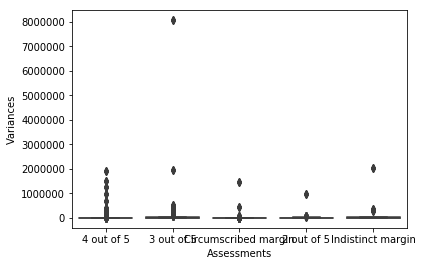

In [208]:
ax = sb.boxplot(x="Assessments", y="Variances", data=df)

In [219]:

    
showNodule(noduleUID="2.25.12352143444889873032471253409309646633514842757276545727426", showIn="slicer")

Nodule 2 - Annotation IL057_159648
LIDC-IDRI-0052
1.3.6.1.4.1.14519.5.2.1.6279.6001.305234403531996676303325051420
1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084
Written content to /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmpmb0q8l5b.py
b'Switch to module:  "Welcome"\nSwitching to temporary DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nOriginal DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nInput directory: /Users/fedorov/Documents/TCIA/LIDC-IDRI/LIDC-IDRI-0052/1.3.6.1.4.1.14519.5.2.1.6279.6001.305234403531996676303325051420/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084\nNew patient inserted: 1\nNew patient inserted as :  1\nNeed to insert new study:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.305234403531996676303325051420"\nStudy Added\nNeed to insert new series:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084"\nSeries Added\n"DICOM indexer has successfully processed 272 files [2.49s]"\

In [176]:
measurementsWithContext.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator',
       'measurementAlgorithmIdentification_AlgorithmName',
       'measurementAlgorithmIdentification_AlgorithmVersion',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'BodyPartExamined', 'EquipmentUID', 'InstitutionName',
       'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientID',
       'PatientName', 'PatientSex', 'PatientWeight', 'ProductId',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID',
       'SeriesTime', 'SoftwareVersions', 'StationName', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime

In [177]:
qualitativeWithContext.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier', 'conceptCode_CodeMeaning',
       'conceptCode_CodeValue', 'conceptCode_CodingSchemeDesignator',
       'conceptValue_CodeMeaning', 'conceptValue_CodeValue',
       'conceptValue_CodingSchemeDesignator', 'BodyPartExamined',
       'EquipmentUID', 'InstitutionName', 'ManufacturerModelName', 'Modality',
       'PatientAge', 'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'ProductId', 'SOPClassUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StationName',
       'StudyDate', 'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

In [56]:
qualitativeWithContext["conceptCode_CodeMeaning"].unique()

array(['Subtlety score', 'Internal structure', 'Calcification',
       'Sphericity', 'Margin', 'Lobular Pattern', 'Spiculation',
       'Texture', 'Malignancy'], dtype=object)

In [120]:
def sortUIDsByMeanVolume(uids):
  measurements = derivedTables["SR1500_Measurements"]
  volumes = []
  largestUID = None
  for uid in uids:
    volumes.append(np.mean([float(v) for v in measurements[(measurements["TrackingUniqueIdentifier"]==uid) 
                            & (measurements["quantity_CodeMeaning"]=="Volume")]["value"].values]))
  return pd.DataFrame({"UID":uids, "Volume":volumes}).sort_values(by="Volume", ascending=False)["UID"]


In [121]:
qualitativeWithContext[qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin"]["conceptValue_CodeMeaning"].unique()

# example of circumscribed margin nodules
circumscribed = qualitativeWithContext[(qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="Circumscribed margin")]["TrackingUniqueIdentifier"]
largestRoundUID = sortUIDsByMeanVolume(circumscribed).values[0]
#showNodule(showIn="slicer", noduleUID=largestRoundUID)

# example of indistinct margin nodules
indistinct = qualitativeWithContext[(qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="Indistinct margin")]["TrackingUniqueIdentifier"]
largestIndistinctUID = sortUIDsByMeanVolume(indistinct).values[0]

# example of spiculated margin nodules
# curious finding: LIDC-IDRI-0127 has two nodule annotations; for one spiculation is scored 1, for the other one 5,
# although tumor is very round. Most likely, one of the readers confused the two extreme scores.
spiculatedSubset = qualitativeWithContext[(qualitativeWithContext["conceptCode_CodeMeaning"]=="Spiculation") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="5 out of 5 (Marked spiculation)")]
largestSpiculatedUID = sortUIDsByMeanVolume(spiculatedSubset["TrackingUniqueIdentifier"]).values[1]


KeyError: 1

In [122]:
largestSpiculatedUID = sortUIDsByMeanVolume(spiculatedSubset["TrackingUniqueIdentifier"])

In [128]:

showNodule(showIn="slicer", noduleUID=largestSpiculatedUID)

Nodule 2 - Annotation IL057_196200
LIDC-IDRI-0790
1.3.6.1.4.1.14519.5.2.1.6279.6001.107063920355575867343721608071
1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223
Slicer python startup script is in
 /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmps0hi5h5b.py
b'Switch to module:  "Welcome"\nSwitching to temporary DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nOriginal DICOM database: /Users/fedorov/Temp/SlicerScripts/CtkDICOMDatabase\nInput directory: /Users/fedorov/Documents/TCIA/LIDC-IDRI/LIDC-IDRI-0790/1.3.6.1.4.1.14519.5.2.1.6279.6001.107063920355575867343721608071/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223\nNew patient inserted: 1\nNew patient inserted as :  1\nNeed to insert new study:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.107063920355575867343721608071"\nStudy Added\nNeed to insert new series:  "1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223"\nSeries Added\n"DICOM indexer has successfully processed 23

/Users/fedorov/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Nodule 3 - Annotation 44303
LIDC-IDRI-1004
1.3.6.1.4.1.14519.5.2.1.6279.6001.100196544861967692255437311943
1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712034597336182402384
Looking for "Nodule 3 - Annotation 44303"
Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>


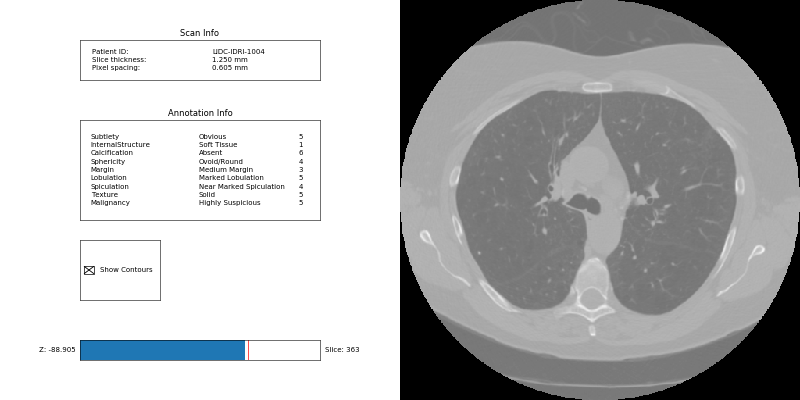

In [144]:
solidUIDs = qualitativeWithContext[(qualitativeWithContext["conceptCode_CodeMeaning"]=="Texture") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="solid pulmonary nodule")]["TrackingUniqueIdentifier"]
solid = qualitativeWithContext[qualitativeWithContext["TrackingUniqueIdentifier"].isin(solidUIDs)]
solidSpiculated = solid[(solid["conceptCode_CodeMeaning"]=="Spiculation") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="5 out of 5 (Marked spiculation)")]
#solidSpiculated[solidSpiculated["conceptValue_CodeMeaning"].describe()
                
showNodule(showIn="pylidc", noduleUID=solidSpiculated["TrackingUniqueIdentifier"].values[1])                
#solid["conceptValue_CodeMeaning"].describe()
#circumscribed = qualitativeWithContext[(qualitativeWithContext["conceptCode_CodeMeaning"]=="Margin") & (qualitativeWithContext["conceptValue_CodeMeaning"]=="Circumscribed margin")]
#circumscribed.describe()



In [110]:
qualitativeWithContext[qualitativeWithContext["PatientID"]=="LIDC-IDRI-0127"].describe()

,SOPInstanceUID,TrackingUniqueIdentifier,conceptCode_CodeMeaning,conceptCode_CodeValue,conceptCode_CodingSchemeDesignator,conceptValue_CodeMeaning,conceptValue_CodeValue,conceptValue_CodingSchemeDesignator,BodyPartExamined,EquipmentUID,...,SeriesDate,SeriesDescription,SeriesInstanceUID,SeriesTime,SoftwareVersions,StationName,StudyDate,StudyDescription,StudyInstanceUID,StudyTime
count,18,18,18,18,18,18,18,18,0.0,0.0,...,18,18,18,18,18,0.0,18,0.0,18,0.0
unique,2,1,9,9,3,13,13,3,0.0,0.0,...,1,2,2,2,1,0.0,1,0.0,1,0.0
top,1.2.276.0.7230010.3.1.4.0.8185.1553291972.389741,2.25.11957746452477851860946304890138640847651...,Internal structure,C41144,NCIt,Circumscribed margin,RID5799,99LIDCQIICR,NaN,NaN,...,20190322,Nodule 1 - Annotation 0 evaluations,1.2.276.0.7230010.3.1.3.0.8183.1553291968.695561,175928,f86b34f,NaN,20000101,NaN,1.3.6.1.4.1.14519.5.2.1.6279.6001.195975724868...,NaN
freq,9,18,2,2,12,2,2,9,NaN,NaN,...,18,9,9,9,18,NaN,18,NaN,18,NaN


Looking for "Nodule 1 - Annotation 12868"
Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>


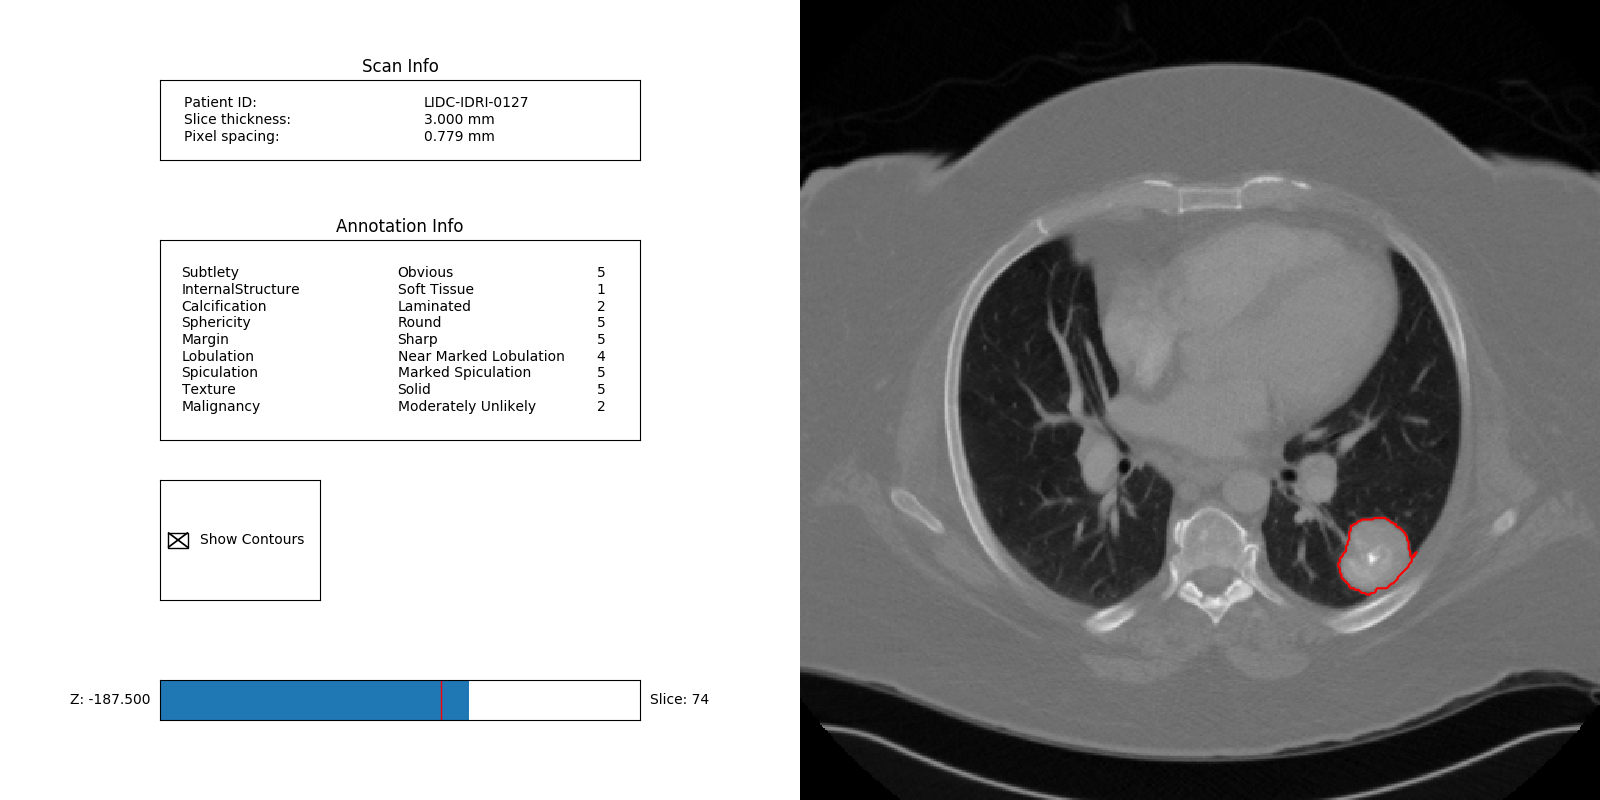

In [111]:
a = getPylidcAnnotationByLabel("LIDC-IDRI-0127", "Nodule 1 - Annotation 12868")
a.visualize_in_scan()